# Overview
In this notebook, we will compare data between iEEG contacts inside the hippocapus vs the rest of the brain in terms of band power. We will then extrapolate these band powers across the hippocampus to see if there are systematic differences.

Note that we have already determined which/where channels are in the hippocampus, and preprocessed the iEEG timeseries and converted them to band power values in the `../extras` directory. See there for methodological details

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import pandas as pd
import scipy.io
from scipy.signal import periodogram
import pygeodesic.geodesic as geodesic

In [6]:
den='2mm'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
ind = [range(419), range(419,483)] # index of how many dentate and hipp vertices are
shp = [419]#,64]
freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = np.array([[0.5,4], [4,8], [8,13], [13,30], [30,80]])
sampspace = np.arange(0.5,80,0.5)
dist_threshold = 5 #mm

In [7]:
# load preprocessed bandpower and periogram data
# all data is all clean channels, hipp dat has non-hippocmapal channels NaN'd out

vars_to_load = ['pxx', 'bp', 'hipp_bp', 'hipp_pxx']
t1 = np.load(f'../checkpoints/iEEG_Frauscher_dat.npy',allow_pickle=True)
t2 = np.load(f'../checkpoints/iEEG_MICs_dat.npy',allow_pickle=True)

In [8]:
all_pxx = np.concatenate((t1[0], t2[0]),axis=1)
all_bp = np.concatenate((t1[1], t2[1]),axis=0)
all_hippbp = np.concatenate((t1[2],t2[2]),axis=3)
all_hipppxx = np.concatenate((t1[3],t2[3]),axis=3)

In [9]:
nL = len(np.where(np.any(~np.isnan(all_hippbp[:,0,0,:]),axis=0))[0])
nR = len(np.where(np.any(~np.isnan(all_hippbp[:,1,0,:]),axis=0))[0])

print('number of L hemis: ' + str(nL))
print('number of R hemis: ' + str(nR))

number of L hemis: 26
number of R hemis: 55


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


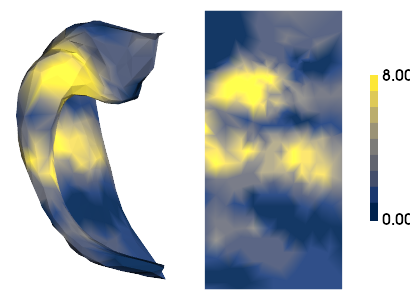

In [10]:
hipp_dat_count = np.sum(~np.isnan(all_hippbp),axis=(1,3))[:,0]
plotting.surfplot_canonical_foldunfold(hipp_dat_count, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(0.4, 100)

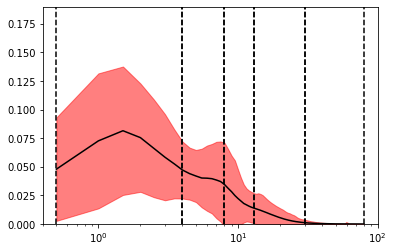

In [11]:
y = np.exp(np.nanmean(np.log(all_pxx),axis=1))
err = np.nanstd(all_pxx,axis=1)
plt.plot(sampspace,y,'k-')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

(0.4, 100)

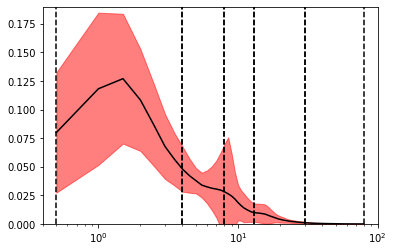

In [12]:
y = np.exp(np.nanmean(np.log(all_hipppxx),axis=(0,1,3)))
err = np.nanstd(all_hipppxx,axis=(0,1,3))
plt.plot(sampspace,y,'k-')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

## Overall Band power
Here we simply compare all iEEG contact to the subset that are specifically coming from within the hippocampus

/data/mica1/01_programs/tmp/ipykernel_39934/2404064222.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


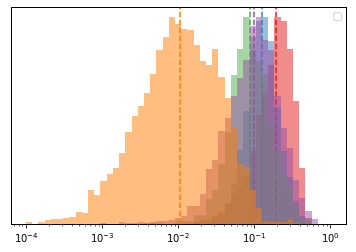

In [13]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = all_bp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

/data/mica1/01_programs/tmp/ipykernel_39934/4098845490.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


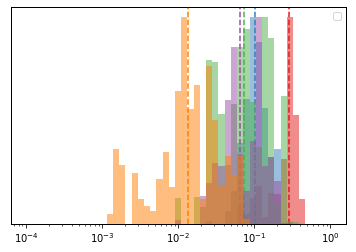

In [14]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = all_hippbp[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

## Extrapolation
We can see that simply averaging over all channels doesn't give a good idea of the spatial distribution of band power, since so much data is missing. Thus, we will extrapolate each channel over the whole hippocampus and then use the distance from the channel as a weighting when performing weighted averaging across channels. See `../extras` for an example visualization.

In [15]:
surfL = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
surfR = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
vertices = np.stack((surfL.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data,surfR.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data),axis=2)
faces = surfL.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

In [16]:
weights_hipp_dat = np.zeros((all_hippbp.shape[0],2,all_hippbp.shape[3]))
interp_hipp_dat = np.zeros([all_hippbp.shape[0],5])
interp_hipp_perio_dat = np.zeros([all_hippbp.shape[0],len(all_pxx)])

for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):
        for c in range(all_hippbp.shape[3]):
            dat = all_hippbp[:,h,0,c]
            mask = ~np.isnan(dat[ind[l]])
            if np.any(mask):
                geoalg = geodesic.PyGeodesicAlgorithmExact(vertices[:,:,h], faces)
                sd,_ = geoalg.geodesicDistances(np.where(mask)[0], None)
                weights_hipp_dat[ind[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_dat, axis=(1,2))
for v in range(weights_hipp_dat.shape[0]):
    for h in range(2):
        for c in range(all_hippbp.shape[3]):
            w = weights_hipp_dat[v,h,c] / totweights[v]
            if w>0:
                interp_hipp_dat[v,:] += np.nanmean(all_hippbp[:,h,:,c],axis=0) * w
                interp_hipp_perio_dat[v,:] += np.nanmean(all_hipppxx[:,h,:,c],axis=0) * w

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


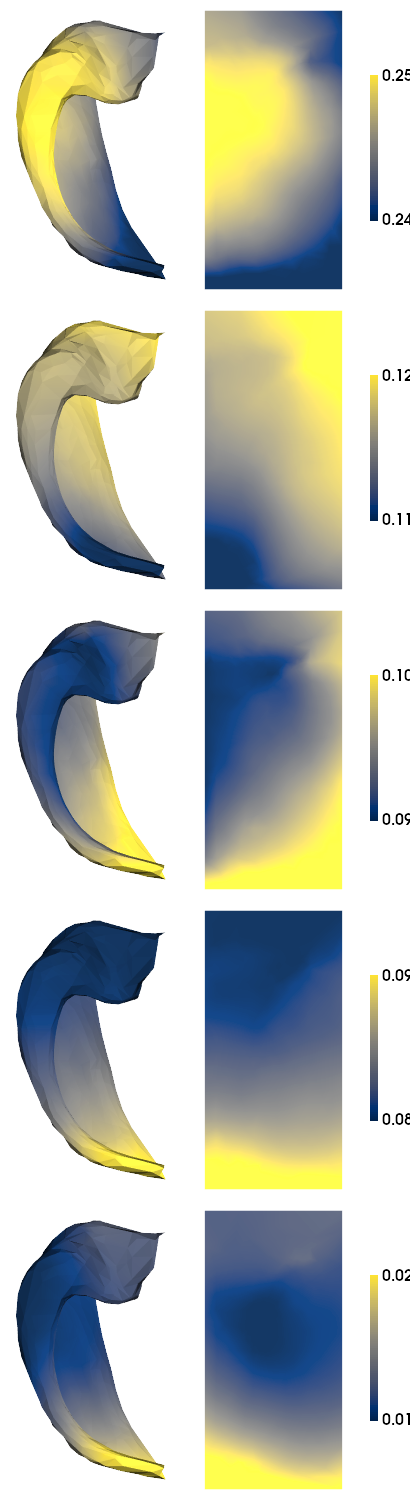

In [17]:
plotting.surfplot_canonical_foldunfold(interp_hipp_dat, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

In [18]:
from brainspace.gradient import GradientMaps
# gradient decomposition
bpgm = GradientMaps(n_components=5, kernel='pearson')
bpgm.fit(interp_hipp_perio_dat, sparsity=0.1)

GradientMaps(kernel='pearson', n_components=5)

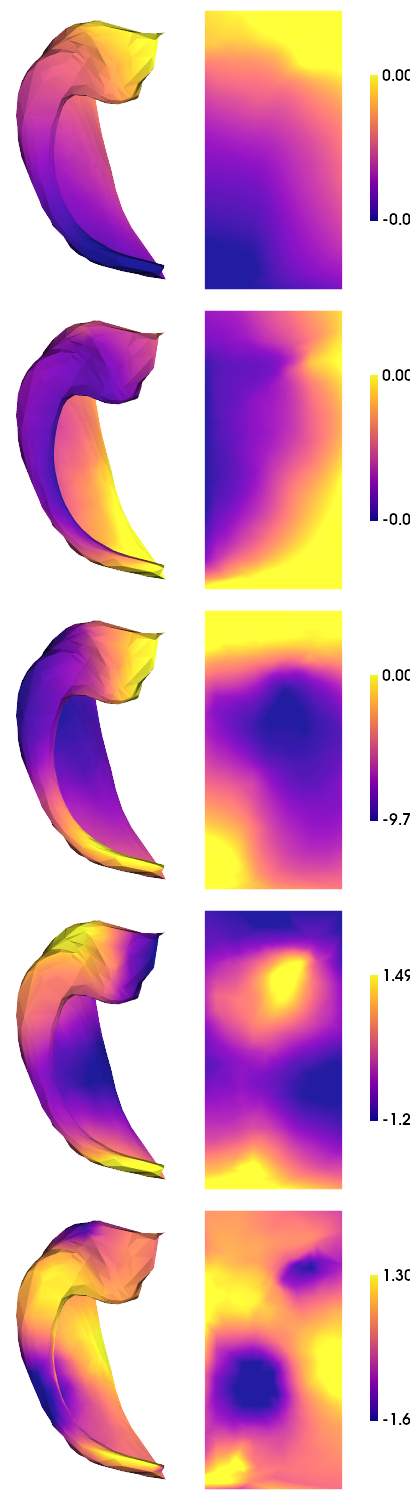

In [19]:
plotting.surfplot_canonical_foldunfold(bpgm.gradients_, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='plasma', share='row', color_bar='right', embed_nb=True)

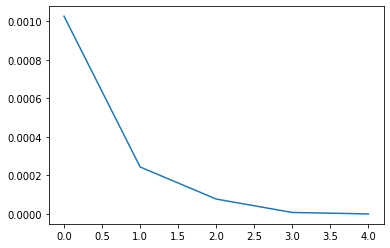

In [20]:
plt.plot(bpgm.lambdas_)

In [21]:
bpgm.lambdas_/np.sum(bpgm.lambdas_)

array([7.55756580e-01, 1.79956117e-01, 5.74302210e-02, 6.18407310e-03,
       6.73009269e-04])

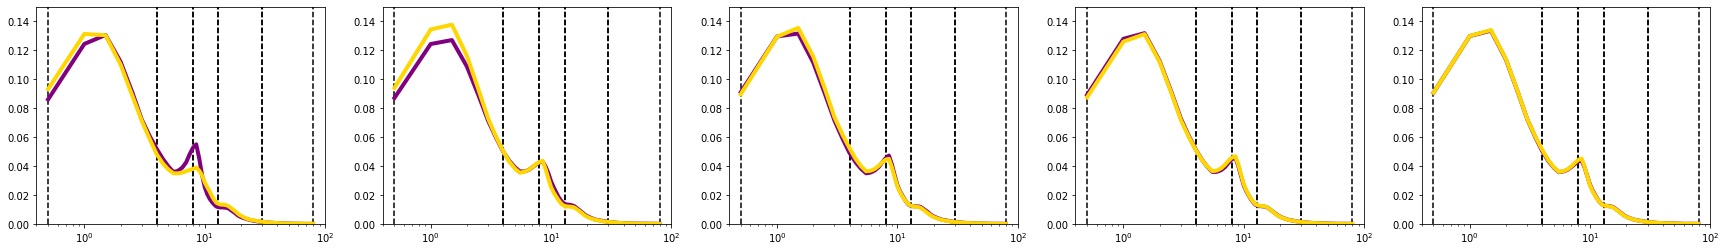

In [22]:
# compare top to bottom
n_components=5
fig, ax = plt.subplots(nrows=1, ncols=n_components, figsize=(6*n_components,4))

for c in range(n_components):

    nverts = np.sum(shp)
    nvertsplit = int(nverts*.1)

    bot = np.argpartition(bpgm.gradients_[:,c],nvertsplit)[:nvertsplit]
    top = np.argpartition(bpgm.gradients_[:,c],-nvertsplit)[-nvertsplit:]

    ax[c].plot(sampspace,np.mean(interp_hipp_perio_dat[top,:],axis=0),color='purple', linewidth=4)
    ax[c].plot(sampspace,np.mean(interp_hipp_perio_dat[bot,:],axis=0),color='gold', linewidth=4)
    #ax[c].set_yscale('log')
    ax[c].set_xscale('log')
    ax[c].set_xlim(0.4,100)
    ax[c].set_ylim(0,.15)
    ax[c].vlines(band_lims.flatten(),ax[c].get_ylim()[0],ax[c].get_ylim()[1],colors='k',linestyles='--')

In [23]:
# save a copy of the 2D map
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/
for b,band in enumerate(bands):
    cdat = interp_hipp_dat[:,b]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-{band}_average-{nL+nR}_hemi-mix_den-{den}_label-{label}.shape.gii')

In [24]:
# save a copy of the 2D map
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/
for l,label in enumerate(labels):    
    cdat = bpgm.gradients_
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-G1to5_average-{nL+nR}_hemi-mix_den-{den}_label-{label}.shape.gii')